In [146]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [147]:
def qpsk_augmentation(x):
    x = x.clone()

    # 1. Добавляем белый шум (иногда разный по I/Q)
    if torch.rand(1).item() < 0.8:
        noise_level = torch.rand(1).item() * 0.1
        noise = torch.randn_like(x) * noise_level
        x += noise
    
    # 4. Джиттер по времени (мелкие искажения)
    if torch.rand(1).item() < 0.7:
        jitter = torch.randn_like(x) * 0.01
        x += torch.sin(torch.linspace(0, 2 * np.pi, x.shape[1], device=x.device)) * jitter

    return x


In [148]:
class QPSKDataset(Dataset):
    def __init__(self, num_samples, time, symbol_rate, sample_rate, carrying_freq, augment_fn):
        self.num_samples = num_samples
        self.time = time
        self.symbol_rate = symbol_rate
        self.sample_rate = sample_rate
        self.carrying_freq = carrying_freq
        self.augment_fn = augment_fn
        self.samples_per_symbol = int(sample_rate / symbol_rate)

    def __len__(self):
        return self.num_samples

    def generate_qpsk(self):
        num_symbols = int(self.time * self.symbol_rate)
        num_samples = int(self.time * self.sample_rate)
        samples_per_symbol = int(self.sample_rate / self.symbol_rate)

        bits = np.random.randint(0, 2, size=num_symbols * 2)
        symbols = bits.reshape(-1, 2)

        phase_map = {
            (0, 0): (1, 1),
            (0, 1): (-1, 1),
            (1, 1): (-1, -1),
            (1, 0): (1, -1)
        }

        iq = np.array([phase_map[tuple(b)] for b in symbols])
        i_vals, q_vals = iq[:, 0], iq[:, 1]

        i_samples = np.repeat(i_vals, samples_per_symbol)
        q_samples = np.repeat(q_vals, samples_per_symbol)

        t = np.linspace(0, self.time, int(self.time * self.sample_rate), endpoint=False)

        carrier_cos = np.cos(2 * np.pi * self.carrying_freq * t) * (np.sqrt(2)/2)
        carrier_sin = np.sin(2 * np.pi * self.carrying_freq * t) * (np.sqrt(2)/2)

        signal = i_samples * carrier_cos - q_samples * carrier_sin
        iq_signal = np.stack([i_samples*carrier_cos, q_samples*carrier_sin], axis=0)  # Shape: [2, T]
        return iq_signal.astype(np.float32)

    def __getitem__(self, idx):
        clean = self.generate_qpsk()
        noisy_1 = self.augment_fn(torch.tensor(clean.copy()))
        noisy_2 = self.augment_fn(torch.tensor(clean.copy()))
        return noisy_1, noisy_2


class QPSKDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, num_workers=4, **signal_params):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.signal_params = signal_params
        self.samples_per_symbol = int(signal_params["sample_rate"] / signal_params["symbol_rate"])

    def setup(self, stage=None):
        self.dataset = QPSKDataset(
            num_samples=10000,
            augment_fn=qpsk_augmentation,
            **self.signal_params
        )
        self.val_dataset = QPSKDataset(
            num_samples=1000,
            augment_fn=qpsk_augmentation,
            **self.signal_params
        )

    def train_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers
        )


    def get_samples_per_symbol(self):
        return self.samples_per_symbol

In [149]:
class TemporalEncoder(nn.Module):
    def __init__(self, input_channels=2, hidden_dim=64, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        mu = self.net(x)
        logvar = torch.zeros_like(mu)
        return mu, logvar


def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std



In [150]:
class TemporalDenoiser(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, latent_dim, kernel_size=3, padding=1)
        )

    def forward(self, z):
        out = self.net(z)
        norm = torch.norm(out, dim=1, keepdim=True) + 1e-8
        return out / norm  # shape: [B, 2, T]



In [ ]:
class QPSKDenoiserVSSL(pl.LightningModule):
    def __init__(self, ema_decay=0.99, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.student = TemporalEncoder()
        self.teacher = TemporalEncoder()
        self.denoiser = TemporalDenoiser()
        self.ema_decay = ema_decay
        self.lr = lr
        self.register_buffer("global_step_float", torch.tensor(0.0))
        self._update_teacher(0.0)

    def _update_teacher(self, decay=None):
        decay = self.ema_decay if decay is None else decay
        for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
            t_param.data = decay * t_param.data + (1.0 - decay) * s_param.data

    def forward(self, x):
        mu, logvar = self.student(x)
        z = reparameterize(mu, logvar)
        return self.denoiser(z)

    def training_step(self, batch, batch_idx):
        x1, x2 = batch
        with torch.no_grad():
            p_mu, p_logvar = self.teacher(x1)

        mu, logvar = self.student(x2)
        z = reparameterize(mu, logvar)
        z_hat = self.denoiser(z)

        samples_per_symbol = self.trainer.datamodule.get_samples_per_symbol()
        phase = torch.atan2(z_hat[:, 1], z_hat[:, 0])  # [B, T]
        T = phase.shape[1]
        num_symbols = T // samples_per_symbol
        phase_reshaped = phase[:, :num_symbols * samples_per_symbol].reshape(-1, num_symbols, samples_per_symbol)
        symbol_phases = phase_reshaped.mean(dim=-1)
        phase_variance_loss = -symbol_phases.std(dim=-1).mean()

        kl = 0.5 * torch.sum(
            torch.exp(logvar - p_logvar)
            + (mu - p_mu) ** 2 / torch.exp(p_logvar)
            - 1 + p_logvar - logvar,
            dim=1
        ).mean()

        with torch.no_grad():
            z_target = reparameterize(p_mu, p_logvar)
            z_target = z_target / (torch.norm(z_target, dim=1, keepdim=True) + 1e-8)

        recon_loss = F.mse_loss(z_hat, z_target) 

        phase_diff = torch.diff(phase, dim=1)
        phase_smoothness = (phase_diff ** 2).mean()

        loss = 10*kl + recon_loss + 0.3 * phase_smoothness 

        self.log_dict({
            "train/loss": loss,
            "train/kl": kl,
            "train/recon": recon_loss,
            "train/phase_smoothness": phase_smoothness,
            "train/phase_variance_loss": phase_variance_loss
        }, prog_bar=True)

        self._update_teacher()
        self.global_step_float += 1.0
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=200)
        return [opt], [sch]

    def validation_step(self, batch, batch_idx):
        x1, x2 = batch

        with torch.no_grad():
            clean_mu, _ = self.teacher(x1)
            clean_z = reparameterize(clean_mu, torch.zeros_like(clean_mu))
            clean_z = clean_z / (torch.norm(clean_z, dim=1, keepdim=True) + 1e-8)

            mu, logvar = self.student(x2)
            z = reparameterize(mu, logvar)
            z_hat = self.denoiser(z)
            z_hat = z_hat / (torch.norm(z_hat, dim=1, keepdim=True) + 1e-8)

            mse = F.mse_loss(z_hat, clean_z) #Насколько ученик хорошо реконструирует эмбеддинг в латентном пространстве, сген. учителем (не сигнал)
            phase_error = self._phase_error(z_hat, clean_z)

            samples_per_symbol = self.trainer.datamodule.get_samples_per_symbol()
            phase = torch.atan2(z_hat[:, 1], z_hat[:, 0])
            T = phase.shape[1]
            num_symbols = T // samples_per_symbol
            phase_reshaped = phase[:, :num_symbols * samples_per_symbol].reshape(-1, num_symbols, samples_per_symbol)
            symbol_phases = phase_reshaped.mean(dim=-1)
            phase_variance_loss = -symbol_phases.std(dim=-1).mean()

            self.log_dict({
                "val/mse": mse,
                "val/phase_error": phase_error,
                "val/phase_variance_loss": phase_variance_loss
            }, prog_bar=True)

            if batch_idx == 0:
                self._log_phase_plot(phase[0].cpu().numpy(), self.global_step)

    def _phase_error(self, pred, target):
        pred_phase = torch.atan2(pred[:, 1], pred[:, 0])
        target_phase = torch.atan2(target[:, 1], target[:, 0])
        phase_diff = torch.atan2(torch.sin(pred_phase - target_phase), torch.cos(pred_phase - target_phase))
        return torch.abs(phase_diff).mean()

    def _log_phase_plot(self, phi, global_step):
        dphi = np.diff(phi)
        flip_mask = np.abs(dphi) > 1.0
        
        # Create indices for plotting flips - we need to offset by 1 since diff reduces length
        flip_indices = np.where(flip_mask)[0] + 1
        
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(phi, label="ϕ predicted")
        
        # Only plot flips if there are any
        if len(flip_indices) > 0:
            ax.plot(flip_indices, phi[flip_indices], 'rx', label="phase flips")
        
        ax.set_title("Predicted Phase with Flip Points")
        ax.legend()
        ax.grid(True)
        self.logger.experiment.add_figure("phase_validation", fig, global_step)
        plt.close(fig)


In [152]:
signal_params = {
    "time": 5.0,           # длительность сигнала в секундах
    "symbol_rate": 6,   # скорость символов (бод)
    "sample_rate": 120 ,  # частота дискретизации
    "carrying_freq": 12.0  # несущая частота
}

In [153]:

# Создаем дата-модуль
datamodule = QPSKDataModule(
    batch_size=128,
    num_workers=0,
    **signal_params
)


In [154]:

# Создаем модель
model = QPSKDenoiserVSSL(
    ema_decay=0.95,
    lr=1e-3
)


In [155]:
# Создаем логгер для TensorBoard
logger = TensorBoardLogger("tb_logs", name="qpsk_denoiser")
# Создаем тренер
trainer = Trainer(
    max_epochs=1001,
    logger=logger,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    log_every_n_steps=10,
    check_val_every_n_epoch=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [156]:
# Запускаем обучение
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | student  | TemporalEncoder  | 1.2 K  | train
1 | teacher  | TemporalEncoder  | 1.2 K  | train
2 | denoiser | TemporalDenoiser | 834    | train
------------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [157]:
model.eval()

QPSKDenoiserVSSL(
  (student): TemporalEncoder(
    (net): Sequential(
      (0): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (teacher): TemporalEncoder(
    (net): Sequential(
      (0): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (denoiser): TemporalDenoiser(
    (net): Sequential(
      (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(64, 2, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
)

In [158]:
test_dataset = QPSKDataset(
    num_samples=1,
    augment_fn=qpsk_augmentation,
    **signal_params
)

In [159]:
def denoise_signal(model, noisy_signal):
    """
    Очищает QPSK сигнал от шумов
    :param model: обученная модель
    :param noisy_signal: шумный сигнал shape [2, T]
    :return: очищенный сигнал shape [2, T]
    """
    with torch.no_grad():
        # Добавляем batch dimension и переносим на устройство
        x = torch.tensor(noisy_signal).unsqueeze(0).float()
        
        # Получаем скрытое представление
        mu, _ = model.student(x)
        z = reparameterize(mu, torch.zeros_like(mu))
        
        # Денойзинг
        denoised = model.denoiser(z)
        
        # Убираем batch dimension и возвращаем на CPU
        return denoised.squeeze(0).cpu().numpy()

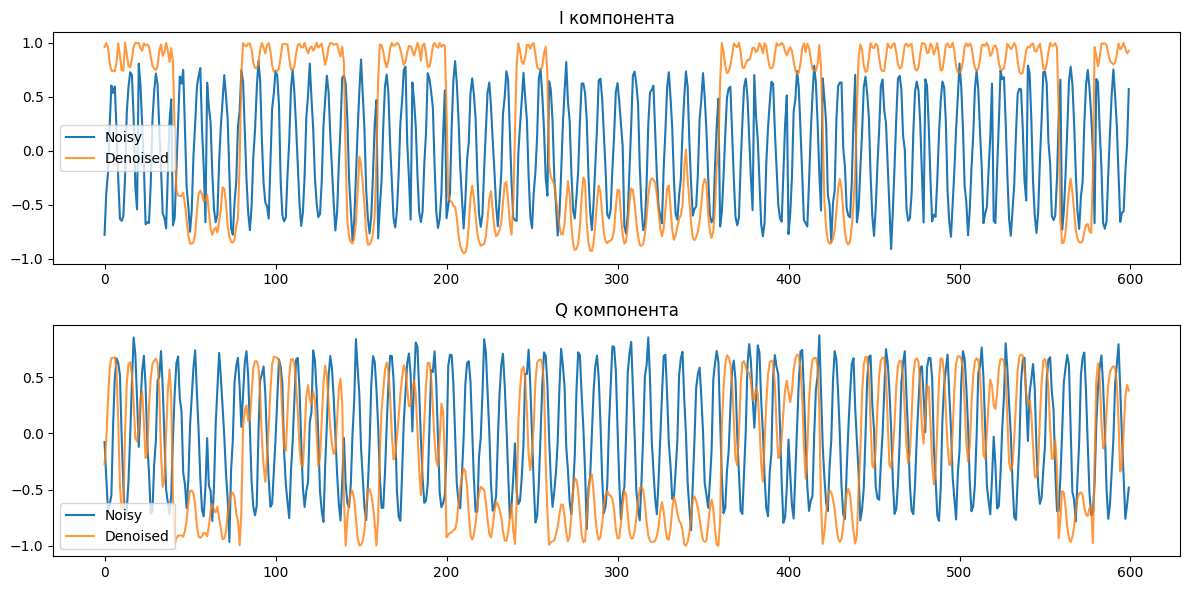

In [160]:
noisy_signal = test_dataset[0][0].numpy()  # shape [2, T]

# Очищаем сигнал
denoised_signal = denoise_signal(model, noisy_signal)

# Визуализация
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("I компонента")
plt.plot(noisy_signal[0], label="Noisy")
plt.plot(denoised_signal[0], label="Denoised", alpha=0.8)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Q компонента")
plt.plot(noisy_signal[1], label="Noisy")
plt.plot(denoised_signal[1], label="Denoised", alpha=0.8)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(denoised_signal[0])



NameError: name 'plt' is not defined

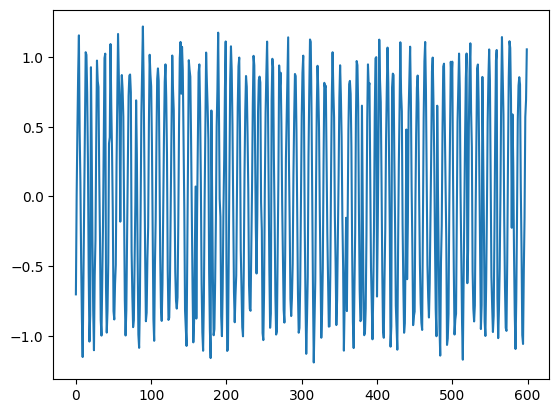

In [168]:
plt.plot(noisy_signal[0]-noisy_signal[1])

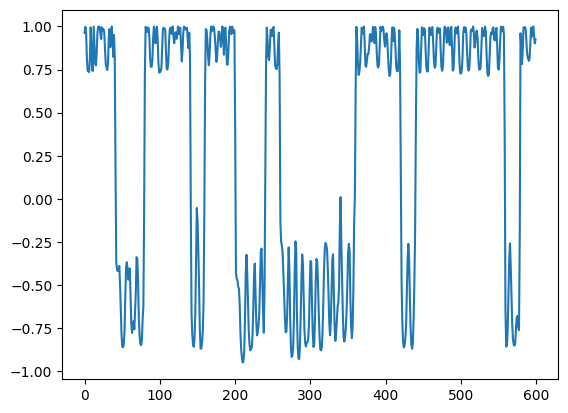

In [169]:
plt.plot(denoised_signal[0])

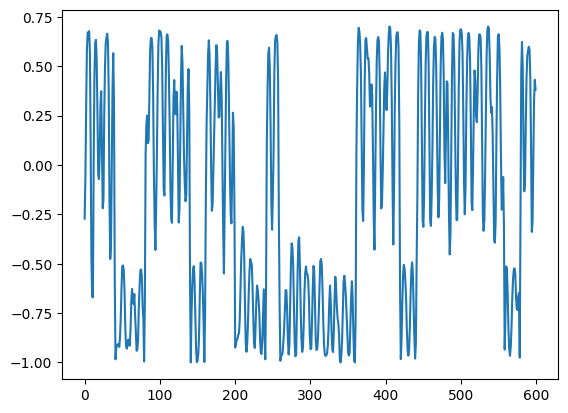

In [170]:
plt.plot(denoised_signal[1])